# Earthquake Predictor ETL

`By Aditya srichandan`

In [1]:
import numpy as np  
import pandas as pd  
from sklearn import preprocessing;
from sklearn import model_selection;
from sklearn import linear_model;
import os
import datetime as dt
import matplotlib.pyplot as plt

#### Get past 30 days earthquake data from [earthquake.usgs.gov](https://earthquake.usgs.gov/earthquakes/feed/v1.0/csv.php) that is being updated every minute (live).
#### Lets import the dataset downloaded from here :- https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv

* Here we are extracting the data from given site and store it in database using SQL engine only for IPYBN and project walkthrough purpose, but in the web application we need live data since the site updates its data every minute. Hence we do not store the data in any database during application deployement but rathar extract the data and perfom only ET (Extract and Transform) and continue the rest of the process.

In [2]:
df=pd.read_csv('2023_march.csv')

### Features in the dataset

* time ---------------------- Time when the event occurred. Times are reported in milliseconds since the epoch 
* latitude ------------------- Decimal degrees latitude. Negative values for southern latitudes.
* longitude ------------------ Decimal degrees longitude. Negative values for western longitudes.
* depth ---------------------- Depth of the event in kilometers.
* mag ------------------------ Magnitude of event occured.
* magType -------------------- The method or algorithm used to calculate the preferred magnitude
* nst ------------------------ The total number of seismic stations used to determine earthquake location.
* gap ------------------------ The largest azimuthal gap between azimuthally adjacent stations (in degrees).
* dmin ----------------------- Horizontal distance from the epicenter to the nearest station (in degrees).
* rms ------------------------ The root-mean-square (RMS) travel time residual, in sec, using all weights.
* net ------------------------- The ID of a data source contributor for event occured.
* id -------------------------- A unique identifier for the event. 
* types ----------------------- A comma-separated list of product types associated to this event.
* place ----------------------- named geographic region near to the event.
* type ------------------------ Type of seismic event.
* locationSource -------------- The network that originally authored the reported location of this event.
* magSource ------------------- Network that originally authored the reported magnitude for this event.
* horizontalError ------------- Uncertainty of reported location of the event in kilometers.
* depthError ------------------ The depth error, three principal errors on a vertical line.
* magError -------------------- Uncertainty of reported magnitude of the event.
* magNst ---------------------- The total number of seismic stations to calculate the magnitude of earthquake.
* status ---------------------- Indicates whether the event has been reviewed by a human.




In [3]:
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2023-03-11T19:20:27.885Z,59.911500,-153.398900,135.40,1.40,ml,NaN,NaN,NaN,0.56,...,2023-03-11T19:22:41.856Z,"41 km ENE of Pedro Bay, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
1,2023-03-11T19:11:58.610Z,56.882400,-156.937800,0.00,1.90,ml,NaN,NaN,NaN,0.74,...,2023-03-11T19:21:08.949Z,"75 km SSE of Ugashik, Alaska",earthquake,NaN,1.00,NaN,NaN,automatic,ak,ak
2,2023-03-11T19:10:41.680Z,51.858000,-178.090333,3.23,1.86,ml,9.0,128.0,NaN,0.16,...,2023-03-11T19:57:47.060Z,"100 km W of Adak, Alaska",earthquake,0.42,0.36,0.232922,9.0,reviewed,av,av
3,2023-03-11T19:09:39.480Z,51.836333,-178.037667,-0.80,0.66,ml,5.0,129.0,NaN,0.31,...,2023-03-11T19:54:25.170Z,"96 km W of Adak, Alaska",earthquake,0.89,3.53,0.238645,4.0,reviewed,av,av
4,2023-03-11T19:09:10.560Z,51.860667,-178.080333,3.31,0.65,ml,5.0,199.0,NaN,0.13,...,2023-03-11T19:51:46.970Z,"Andreanof Islands, Aleutian Islands, Alaska",earthquake,0.54,0.45,0.126377,5.0,reviewed,av,av


In [4]:
df.shape

(11400, 22)

In [5]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,11400.000000,11400.000000,11400.000000,11400.000000,8338.000000,8336.000000,5499.000000,11400.000000,7885.000000,11400.000000,8314.000000,8326.000000
mean,44.178396,-126.130431,23.309613,1.562565,20.056608,128.859157,0.590312,0.296431,1.571551,1.737355,0.224758,15.162863
std,18.405245,62.202031,51.787467,1.216033,23.601392,67.387699,1.869423,0.275771,2.763405,4.287421,0.256392,26.383112
min,-64.335800,-179.968900,-3.500000,-1.230000,0.000000,14.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000
25%,36.528933,-155.323917,2.610000,0.840000,6.000000,75.000000,0.012955,0.090000,0.290000,0.430000,0.120841,5.000000
50%,51.429350,-147.657050,6.990000,1.330000,13.000000,115.000000,0.052320,0.180000,0.500000,0.730000,0.177139,9.000000
75%,58.233333,-117.888650,17.672500,2.000000,25.000000,170.000000,0.193500,0.490000,1.020000,1.420000,0.248000,17.000000
max,86.154600,179.996000,613.906000,6.900000,886.000000,349.000000,33.900000,1.900000,28.260000,232.900000,5.130000,614.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11400 entries, 0 to 11399
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             11400 non-null  object 
 1   latitude         11400 non-null  float64
 2   longitude        11400 non-null  float64
 3   depth            11400 non-null  float64
 4   mag              11400 non-null  float64
 5   magType          11400 non-null  object 
 6   nst              8338 non-null   float64
 7   gap              8336 non-null   float64
 8   dmin             5499 non-null   float64
 9   rms              11400 non-null  float64
 10  net              11400 non-null  object 
 11  id               11400 non-null  object 
 12  updated          11400 non-null  object 
 13  place            11400 non-null  object 
 14  type             11400 non-null  object 
 15  horizontalError  7885 non-null   float64
 16  depthError       11400 non-null  float64
 17  magError    

##### We can see lots of null values of certain features, but as part of data wrangling and feature engineering we consider only certain features in final dataframe, hence I choose simply drop or ignore the null values

In [7]:
df.isnull().sum()

time                  0
latitude              0
longitude             0
depth                 0
mag                   0
magType               0
nst                3062
gap                3064
dmin               5901
rms                   0
net                   0
id                    0
updated               0
place                 0
type                  0
horizontalError    3515
depthError            0
magError           3086
magNst             3074
status                0
locationSource        0
magSource             0
dtype: int64

##### Visualize latitude and longitude feature from 'df' dataframe to see where the points fall from the feature set

Below data has been taken from 2020-07-05 to 2020-08-04 only for project walkthrough, but for the web application that has been deployed [here](http://srichaditya3098.pythonanywhere.com/) queries real time data that updates every minute.

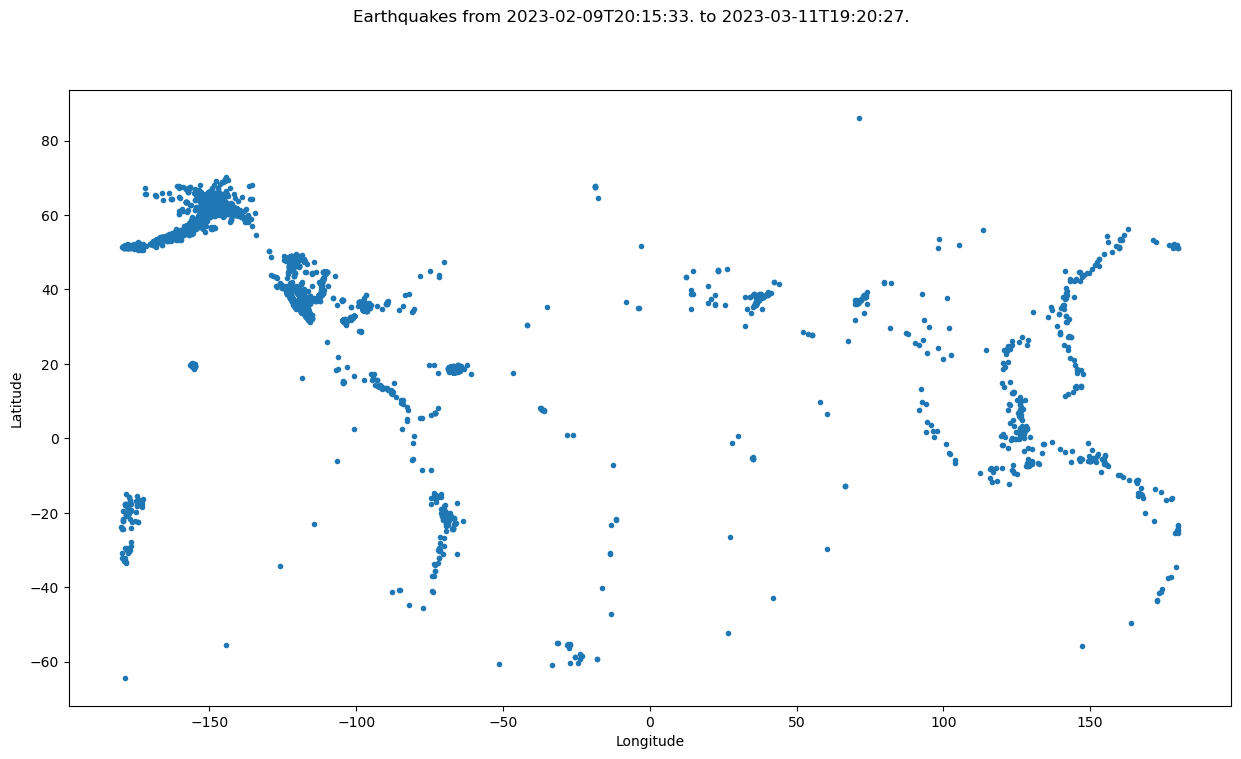

In [8]:
rounding_factor = 10
fig, ax = plt.subplots(figsize=(15,8))

# latitude and longitude of earthquake site of top 10500 samples.
plt.plot(np.round(df['longitude'].head(10500),rounding_factor), 
         np.round(df['latitude'].head(10500),rounding_factor),
         linestyle='none', marker='.')

plt.suptitle('Earthquakes from ' + str(np.min(df['time']))[:20] + ' to ' + str(np.max(df['time']))[:20])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Clean up the data by first extracting only date from 'time' column by considering string[ : 10]. hence we can get desired date

In [9]:
df = df.sort_values('time', ascending=True)

#Date extraction
df['date'] = df['time'].str[0:10]
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,date
11399,2023-02-09T20:15:33.395Z,39.7177,-119.862400,10.50,0.80,ml,3.0,207.44,0.13400,0.0599,...,"9 km N of Lemmon Valley, Nevada",earthquake,NaN,10.200,0.54,3.0,reviewed,nn,nn,2023-02-09
11398,2023-02-09T20:17:16.860Z,-41.6888,42.540800,10.00,4.50,mb,19.0,89.00,19.18700,0.7200,...,Prince Edward Islands region,earthquake,10.88,1.796,0.14,15.0,reviewed,us,us,2023-02-09
11397,2023-02-09T20:21:30.892Z,40.1412,-119.713600,12.00,0.20,ml,3.0,229.57,0.03200,0.1168,...,Nevada,earthquake,NaN,3.600,0.05,2.0,reviewed,nn,nn,2023-02-09
11396,2023-02-09T20:24:04.320Z,36.7535,-121.594500,-0.33,1.25,md,18.0,162.00,0.02597,0.1200,...,"7km ESE of Prunedale, CA",quarry blast,0.36,31.610,0.20,15.0,reviewed,nc,nc,2023-02-09
11395,2023-02-09T20:29:55.520Z,38.7785,-122.756668,1.43,0.75,md,8.0,100.00,0.01052,0.0100,...,"0km N of The Geysers, CA",earthquake,0.33,0.740,0.20,7.0,automatic,nc,nc,2023-02-09


##### Data cleaning for seperating 'place' column. hence only consider city by seperating string by ', '

In [10]:
# only keep the columns needed
df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place']]
# df['date'] = df['time'].str.split(', ', expand=True) 
newdf = df['place'].str.split(', ', expand=True) 


In [11]:
newdf.head()

,0,1,2
11399,9 km N of Lemmon Valley,Nevada,None
11398,Prince Edward Islands region,None,None
11397,Nevada,None,None
11396,7km ESE of Prunedale,CA,None
11395,0km N of The Geysers,CA,None


In [12]:
df['place'] = newdf[1]
df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place']]

In [13]:
df.head()

,date,latitude,longitude,depth,mag,place
11399,2023-02-09,39.7177,-119.862400,10.50,0.80,Nevada
11398,2023-02-09,-41.6888,42.540800,10.00,4.50,None
11397,2023-02-09,40.1412,-119.713600,12.00,0.20,None
11396,2023-02-09,36.7535,-121.594500,-0.33,1.25,CA
11395,2023-02-09,38.7785,-122.756668,1.43,0.75,CA


In [14]:
print('total locations:',len(set(df['place'])))

total locations: 104


#### Bar plot of mean magnitude vs place, as we can see from the graph, only few countries are considered as epicenter or dangerous since they have magnitude more than 2.8 (I have considered here)

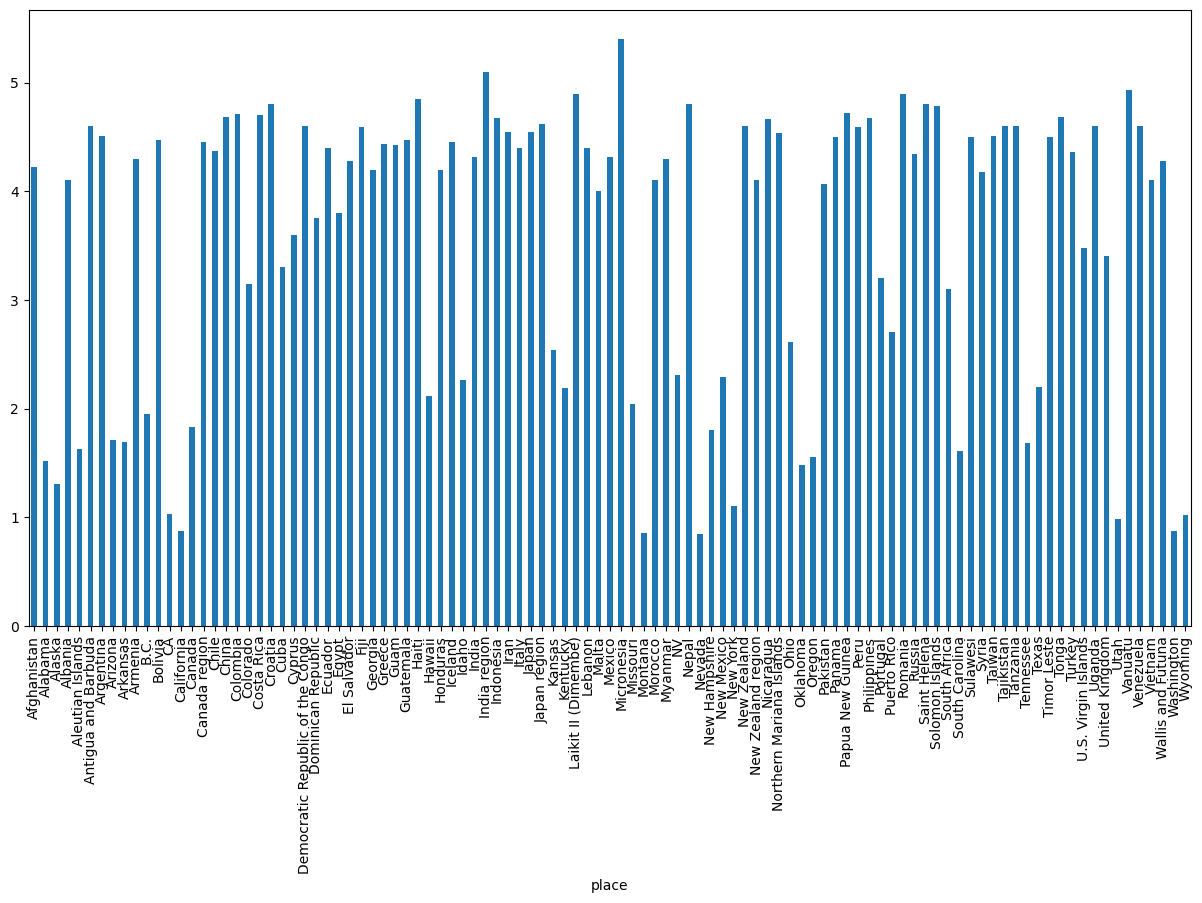

In [15]:
df.groupby(['place'])['mag'].mean().plot(kind='bar',figsize=(15,8));

<AxesSubplot:xlabel='place'>

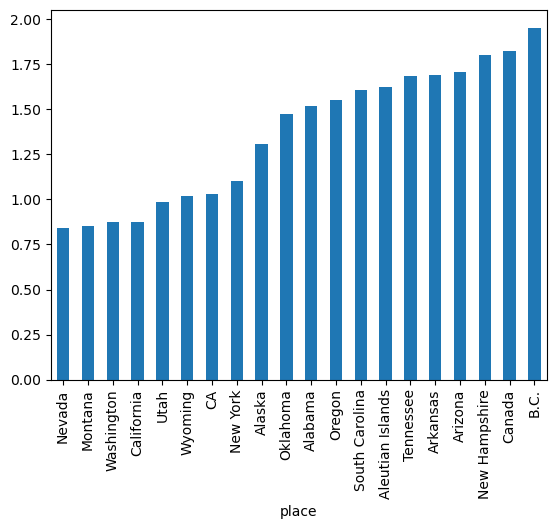

In [16]:
df.groupby(['place'])['mag'].mean().nsmallest(20).plot(kind='bar')

<AxesSubplot:xlabel='place'>

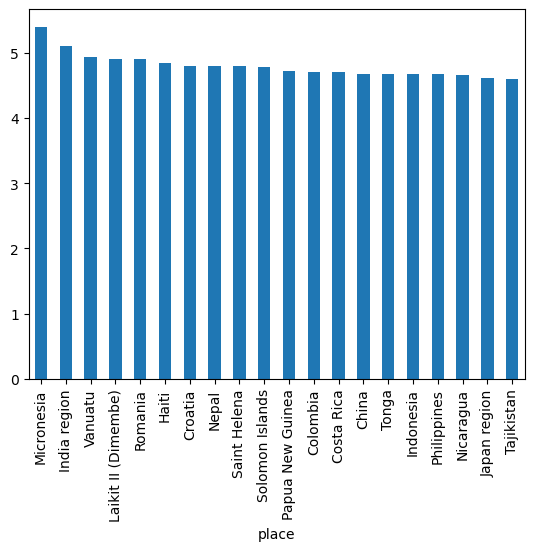

In [17]:
df.groupby(['place'])['mag'].mean().nlargest(20).plot(kind='bar')

In [18]:
more_dangerous_places=df.groupby('place')['mag'].mean()
more_dangerous_places=more_dangerous_places[more_dangerous_places>3]

##### Lets consider 3 as threshold for how high the earthquake has hit and lets visualise countries with more than 3 magnitude.

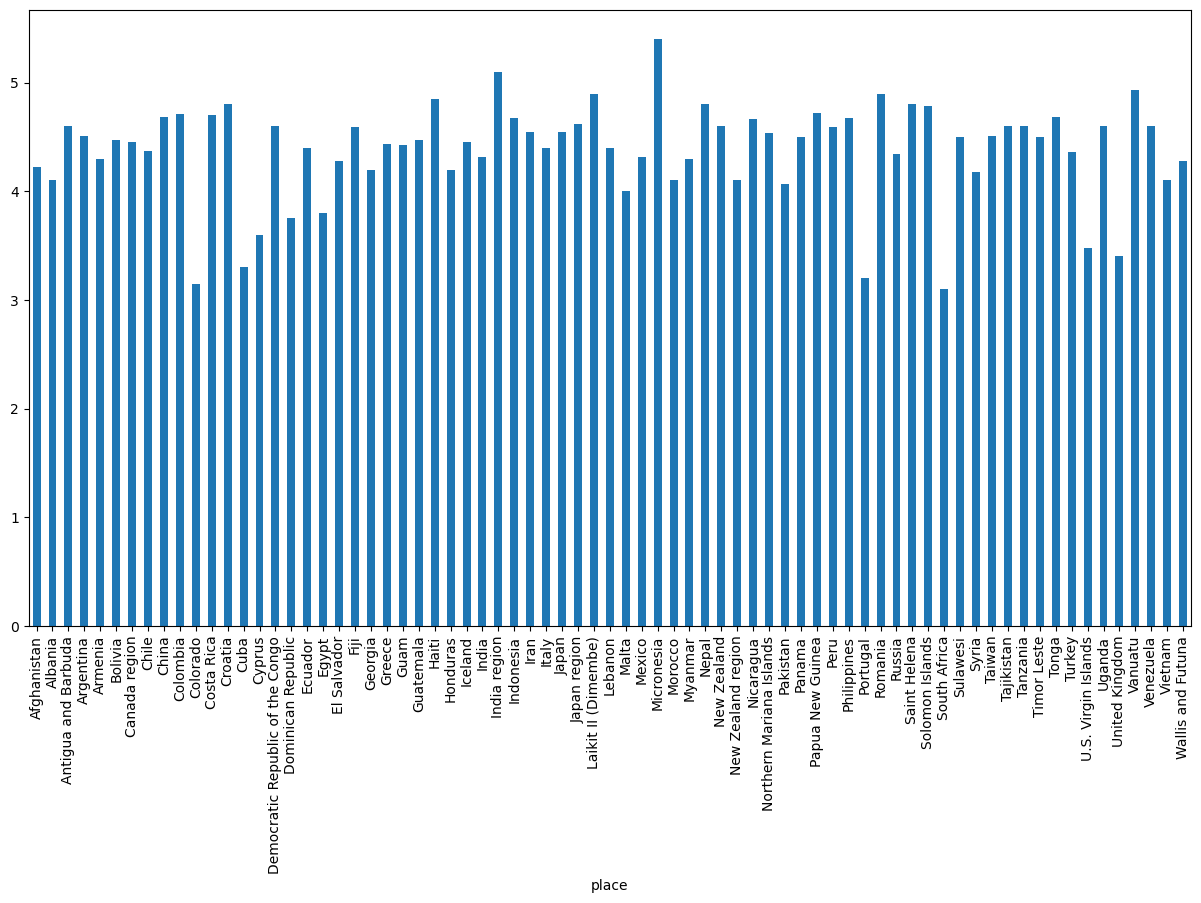

In [19]:
more_dangerous_places.plot(kind='bar',figsize= (15,8));

In [20]:
# calculate mean latitude and longitude for simplified locations

df_coords = df[['place', 'latitude', 'longitude']]
df_coords = df_coords.groupby(['place'], as_index=False).mean()
df_coords = df_coords[['place', 'latitude', 'longitude']]

In [21]:
df_coords.head()

,place,latitude,longitude
0,Afghanistan,36.627360,70.718367
1,Alabama,34.598167,-85.455833
2,Alaska,58.021202,-158.666094
3,Albania,40.987900,19.677000
4,Aleutian Islands,51.938996,-158.493485


#### Merge the two dataframes of mean latitude and longitude locations calculated above with dataframe only considering ['date' , 'depth', 'mag', 'place'] as columns out of total features

In [22]:
df = df[['date', 'depth', 'mag', 'place']]
df = pd.merge(left=df, right=df_coords, how='inner', on=['place'])
df.head()

print('total locations:',len(set(df['place'])))

total locations: 103


In [23]:
print(set(df['place']))

{'Arkansas', 'Venezuela', 'Fiji', 'Utah', 'Wyoming', 'Argentina', 'Ohio', 'Colombia', 'Tanzania', 'Oklahoma', 'Canada region', 'Guam', 'Solomon Islands', 'Vanuatu', 'Arizona', 'Tajikistan', 'Cuba', 'Morocco', 'South Africa', 'Ecuador', 'Romania', 'Afghanistan', 'Malta', 'Micronesia', 'Egypt', 'Dominican Republic', 'Kansas', 'Chile', 'Taiwan', 'Portugal', 'Wallis and Futuna', 'Bolivia', 'Syria', 'Tonga', 'Washington', 'Timor Leste', 'Oregon', 'Missouri', 'Kentucky', 'Croatia', 'Papua New Guinea', 'Italy', 'Georgia', 'Armenia', 'El Salvador', 'Uganda', 'Hawaii', 'NV', 'Pakistan', 'Panama', 'B.C.', 'New Zealand region', 'Nevada', 'Lebanon', 'Costa Rica', 'Guatemala', 'Cyprus', 'China', 'Colorado', 'Northern Mariana Islands', 'New Mexico', 'Indonesia', 'Iceland', 'Greece', 'Albania', 'Puerto Rico', 'Idaho', 'Myanmar', 'New Hampshire', 'Antigua and Barbuda', 'India region', 'Alaska', 'Alabama', 'India', 'Russia', 'Mexico', 'Saint Helena', 'Turkey', 'U.S. Virgin Islands', 'CA', 'Laikit II (D

In [24]:
df.head()

,date,depth,mag,place,latitude,longitude
0,2023-02-09,10.5,0.8,Nevada,37.964535,-117.364326
1,2023-02-09,9.7,-0.2,Nevada,37.964535,-117.364326
2,2023-02-10,11.7,1.6,Nevada,37.964535,-117.364326
3,2023-02-10,0.0,0.1,Nevada,37.964535,-117.364326
4,2023-02-10,9.2,1.2,Nevada,37.964535,-117.364326


#### Feature Engineering and Data wrangling

* Set rolling window size for future prediction based on past values with fixed window size in past
* I have created 6 new features based on rolling window size on average depth and average magnitude.
* A final outcome 'mag_outcome' has been defined as target values and the output is considered as shifted values from set rolling window of past days eg: '7'. 

In [25]:
eq_tmp = df.copy()

#rolling window size
DAYS_OUT_TO_PREDICT = 7

# loop through each zone and apply MA
eq_data = []
eq_data_last_days_out = []

for place in list(set(eq_tmp['place'])):
    temp_df = eq_tmp[eq_tmp['place'] == place].copy()
    
    #avg. depth of 22 days rolling period and so on..
    temp_df['depth_avg_22'] = temp_df['depth'].rolling(window=22,center=False).mean() 
    temp_df['depth_avg_15'] = temp_df['depth'].rolling(window=15,center=False).mean()
    temp_df['depth_avg_7'] = temp_df['depth'].rolling(window=7,center=False).mean()
    temp_df['mag_avg_22'] = temp_df['mag'].rolling(window=22,center=False).mean() 
    temp_df['mag_avg_15'] = temp_df['mag'].rolling(window=15,center=False).mean()
    temp_df['mag_avg_7'] = temp_df['mag'].rolling(window=7,center=False).mean()
    temp_df.loc[:, 'mag_outcome'] = temp_df.loc[:, 'mag_avg_7'].shift(DAYS_OUT_TO_PREDICT * -1)
    
    #days to predict value on earth quake data this is not yet seen or witnessed by next 7 days (consider as live next 7 days period)
    
    eq_data_last_days_out.append(temp_df.tail(DAYS_OUT_TO_PREDICT))

    eq_data.append(temp_df)

In [26]:
# concat all location-based dataframes into master dataframe
eq_all = pd.concat(eq_data)

In [27]:
eq_all.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
10313,2023-02-11,8.790,1.09,Arkansas,35.358444,-91.490111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10314,2023-02-27,8.310,2.08,Arkansas,35.358444,-91.490111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10315,2023-03-01,1.690,1.91,Arkansas,35.358444,-91.490111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10555,2023-03-03,6.875,4.60,Venezuela,8.280300,-72.191800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10342,2023-02-12,535.236,4.30,Fiji,-17.794136,-113.871382,NaN,NaN,NaN,NaN,NaN,NaN,4.614286


In [28]:
# remove any NaN fields
eq_all = eq_all[np.isfinite(eq_all['depth_avg_22'])]
eq_all = eq_all[np.isfinite(eq_all['mag_avg_22'])]
eq_all = eq_all[np.isfinite(eq_all['mag_outcome'])]

In [29]:
eq_all.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
9142,2023-02-16,3.32,1.69,Utah,39.706944,-112.278967,5.732727,6.249333,6.334286,1.196818,1.238667,1.511429,0.698571
9143,2023-02-16,0.53,-0.26,Utah,39.706944,-112.278967,5.910455,5.754667,4.554286,1.113636,1.176667,1.265714,1.152857
9144,2023-02-16,5.01,0.36,Utah,39.706944,-112.278967,6.012273,5.925333,4.437143,1.062273,1.003333,1.075714,1.250000
9145,2023-02-17,5.37,0.91,Utah,39.706944,-112.278967,6.025000,5.922667,4.204286,1.134091,1.012000,1.044286,1.205714
9146,2023-02-17,7.09,0.90,Utah,39.706944,-112.278967,6.096364,6.022667,4.820000,1.115000,1.033333,1.007143,1.165714


#### location after feature engineering

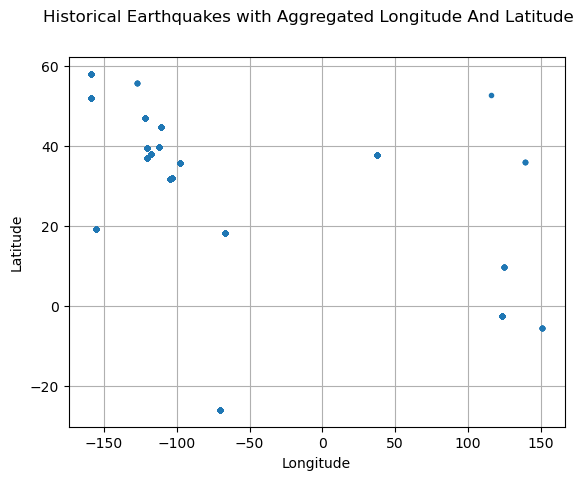

In [30]:
plt.plot(eq_all['longitude'], 
         eq_all['latitude'],
         linestyle='none', marker='.')
plt.suptitle('Historical Earthquakes with Aggregated Longitude And Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()


In [31]:
# keep our live data for predictions
eq_data_last_days_out = pd.concat(eq_data_last_days_out)


eq_data_last_days_out = eq_data_last_days_out[np.isfinite(eq_data_last_days_out['mag_avg_22'])]
predict_unknown=eq_data_last_days_out

In [32]:
# here 'mag_outcome' has NaN because these are future outcome event to be predicted live or data that has not yet been witnessed
predict_unknown

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
9189,2023-03-07,7.630,1.69,Utah,39.706944,-112.278967,4.565455,6.140000,7.581429,1.155000,1.145333,1.341429,NaN
9190,2023-03-07,9.650,2.68,Utah,39.706944,-112.278967,4.993182,6.414000,6.020000,1.285909,1.256667,1.467143,NaN
9191,2023-03-07,9.350,1.22,Utah,39.706944,-112.278967,5.418182,6.490000,5.697143,1.330909,1.213333,1.414286,NaN
9192,2023-03-08,9.970,1.91,Utah,39.706944,-112.278967,5.881818,6.992667,7.527143,1.364091,1.332667,1.438571,NaN
9193,2023-03-09,2.490,2.28,Utah,39.706944,-112.278967,6.145455,7.140000,6.588571,1.387273,1.444667,1.602857,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9004,2023-03-06,150.059,4.80,Philippines,9.823771,124.523266,68.743136,50.283467,73.162429,4.622727,4.646667,4.742857,NaN
9005,2023-03-07,38.647,6.00,Philippines,9.823771,124.523266,70.045273,52.193267,77.254857,4.690909,4.740000,4.928571,NaN
9006,2023-03-07,10.000,5.60,Philippines,9.823771,124.523266,70.045273,52.193267,60.030714,4.736364,4.820000,5.085714,NaN
9007,2023-03-08,14.439,4.50,Philippines,9.823771,124.523266,44.200500,52.489200,54.964143,4.754545,4.800000,5.042857,NaN


##### considered magnitude above 2.5 as dangerous hence prediction outcome as '1' elso '0'.

In [33]:
eq_all['mag_outcome'] = np.where(eq_all['mag_outcome'] > 2.5, 1,0)
print(eq_all['mag_outcome'].describe())
eq_all['mag_outcome'].value_counts()

count    9479.000000
mean        0.037873
std         0.190900
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: mag_outcome, dtype: float64


0    9120
1     359
Name: mag_outcome, dtype: int64

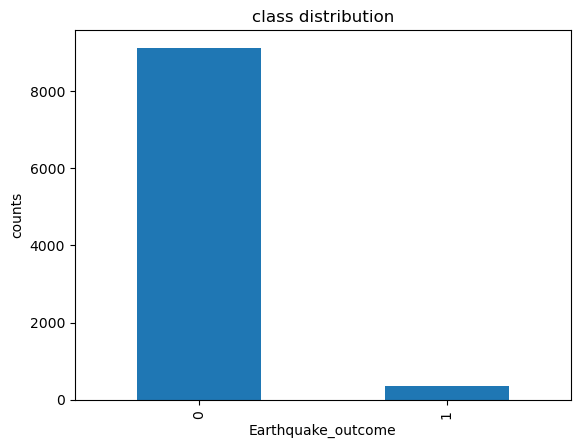

In [34]:
eq_all['mag_outcome'].value_counts().plot(kind='bar',)
plt.xlabel('Earthquake_outcome')
plt.ylabel('counts')
plt.title('class distribution');

##### Save the data of of fixed rolling window and live unknown prediction data in sql database using sql engine 

In [35]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///2023_march.db')
eq_all.to_sql('Earthquake_features', engine, index=False,if_exists='replace')

9479

In [36]:
engine = create_engine('sqlite:///2023_march_predict.db')
predict_unknown.to_sql('Earthquake_predict', engine, index=False,if_exists='replace')

161